# Machine Learning HWS24
## Assignment 4
### Nursultan Mamatov, nmamatov, 1983726
### Cagan Yigit Deliktas, cdelikta, 1979012

In [1]:
import numpy as np
import scipy
import scipy.stats
import matplotlib.pyplot as plt
from IPython import get_ipython
from numpy.linalg import svd
from util import nextplot, plot_xy
from sklearn.cluster import KMeans

# setup plotting
import psutil
inTerminal = not "IPKernelApp" in get_ipython().config
inJupyterNb = any(filter(lambda x: x.endswith("jupyter-notebook"), psutil.Process().parent().cmdline()))
inJupyterLab = any(filter(lambda x: x.endswith("jupyter-lab"), psutil.Process().parent().cmdline()))
if not inJupyterLab:
    from IPython import get_ipython
    get_ipython().run_line_magic("matplotlib", "" if inTerminal else "notebook" if inJupyterNb else "widget")

# 1 Probabilistic PCA

## 1a) Toy data

In [2]:
# You do not need to modify this method.
def ppca_gen(N=10000, D=2, L=2, sigma2=0.5, mu=None, lambda_=None, Q=None, seed=None):
    """Generate data from a given PPCA model.

    Unless specified otherwise, uses a fixed mean, fixed eigenvalues (variances along
    principal components), and a random orthogonal eigenvectors (principal components).

    """

    # determine model parameters (from arguments or default)
    rng = np.random.RandomState(seed)
    if mu is None:
        mu = np.arange(D) + 1.0
    if Q is None:
        Q = scipy.stats.ortho_group.rvs(D, random_state=rng)
    if lambda_ is None:
        lambda_ = np.arange(D, 0, -1) * 2

    # weight matrix is determined from first L eigenvectors and eigenvalues of
    # covariance matrix
    Q_L = Q[:, :L]
    lambda_L = lambda_[:L]
    W = Q_L * np.sqrt(lambda_L)  # scales columns

    # generate data
    Z = rng.standard_normal(size=(N, L))  # latent variables
    Eps = rng.standard_normal(size=(N, D)) * np.sqrt(sigma2)  # noise
    X = Z @ W.transpose() + mu + Eps  # data points

    # all done
    return dict(
        N=N, D=D, L=L, X=X, Z=Z, mu=mu, Q_L=Q_L, lambda_L=lambda_L, W=W, Eps=Eps
    )

In [3]:
# You do not need to modify this method.
def ppca_plot_2d(data, X="X", mu="mu", W="W", alpha=0.05, axis=None, **kwargs):
    """Plot 2D PPCA data along with its weight vectors."""
    if not axis:
        nextplot()
        axis = plt.gca()
    X = data[X] if isinstance(X, str) else X
    plot_xy(X[:, 0], X[:, 1], alpha=alpha, axis=axis, **kwargs)

    # additional plot elements: mean and components
    if mu is not None:
        mu = data[mu] if isinstance(mu, str) else mu
        if W is not None:
            W = data[W] if isinstance(W, str) else W
            head_width = np.linalg.norm(W[:, 0]) / 10.0
            for j in range(W.shape[1]):
                axis.arrow(
                    mu[0],
                    mu[1],
                    W[0, j],
                    W[1, j],
                    length_includes_head=True,
                    head_width=head_width,
                )

273244.3990646409


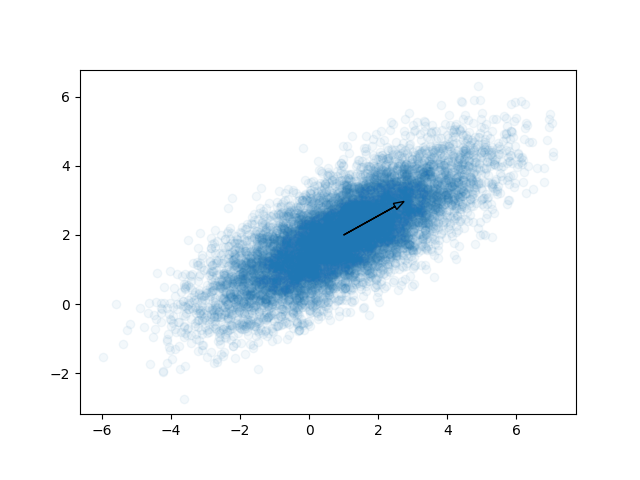

In [4]:
# Generate and plot a toy dataset
toy_ppca = ppca_gen(L=1, sigma2=0.5, seed=0)
ppca_plot_2d(toy_ppca)
print(np.sum(toy_ppca["X"] ** 3))  # must be 273244.3990646409

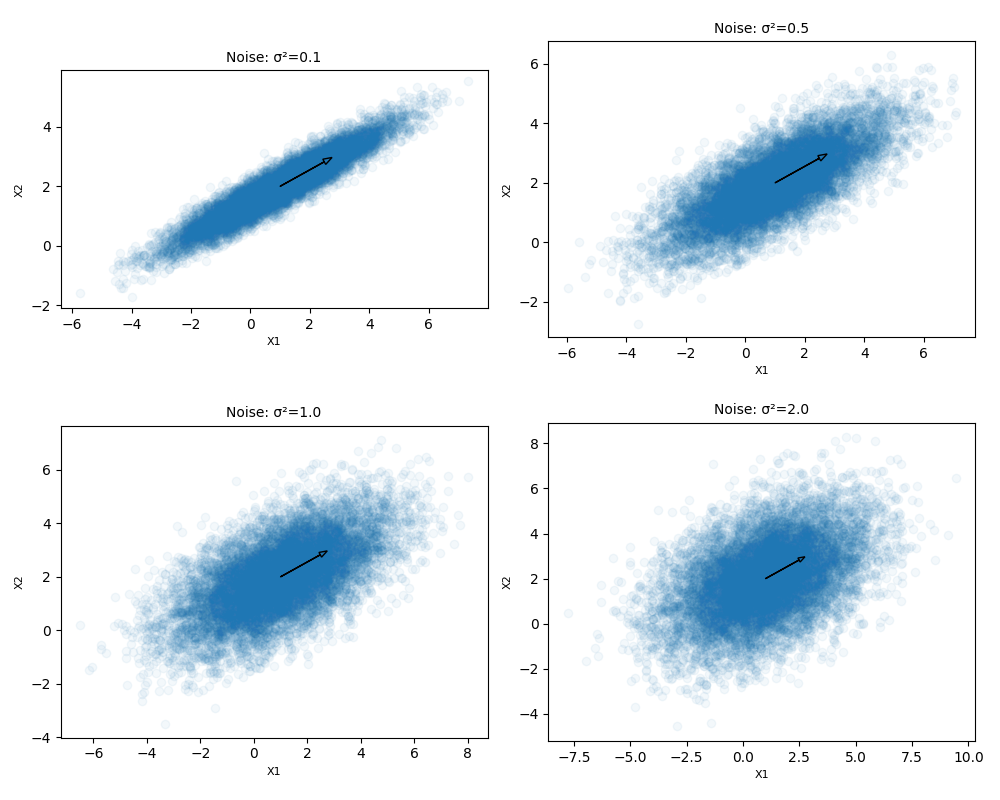

In [5]:
# Function to generate and plot PPCA data for varying noise levels
def plot_ppca_with_noise(noise_levels, seed=0):
    """
    Plots PPCA data for different noise levels in a 2x2 grid layout.
    """
    # Set up the figure size and grid layout
    rows = 2
    cols = 2
    fig_width = 10  # Total width for the figure
    fig_height = 8  # Total height for the figure
    plt.figure(figsize=(fig_width, fig_height))  # Define overall figure size
    
    for i, sigma2 in enumerate(noise_levels):
        # Create a subplot in a 2x2 grid
        ax = plt.subplot(rows, cols, i + 1)  # (rows, cols, index)
        
        # Generate toy PPCA dataset with a specific noise level
        toy_ppca = ppca_gen(L=1, sigma2=sigma2, seed=seed)
        
        # Plot the data on the current axis
        ppca_plot_2d(toy_ppca, axis=ax)
        
        # Set titles and labels for clarity
        ax.set_title(f"Noise: σ²={sigma2}", fontsize=10)
        ax.set_xlabel("X1", fontsize=8)
        ax.set_ylabel("X2", fontsize=8)
    
    # Use tight layout to optimize spacing
    plt.tight_layout()
    plt.show()

# Test with varying noise levels
noise_levels = [0.1, 0.5, 1.0, 2.0]  # Different values of σ²
plot_ppca_with_noise(noise_levels)

## 1b) Maximum Likelihood Estimation

In [6]:
def ppca_mle(X, L):
    """
    Computes the ML estimates of PPCA model parameters.

    Parameters:
        X (np.ndarray): Data matrix of shape (N, D), where N is the number of samples and D is the dimensionality.
        L (int): Number of latent dimensions.

    Returns:
        dict: A dictionary with keys `mu`, `W`, and `sigma2` containing the MLE estimates.
    """
    # Get dimensions
    N, D = X.shape

    # Step 1: Compute the mean
    mu_mle = np.mean(X, axis=0)

    # Step 2: Center the data
    X_centered = X - mu_mle

    # Step 3: Perform SVD
    U, S, Vt = np.linalg.svd(X_centered, full_matrices=False)

    # Step 4: Compute W_mle
    V_L = Vt[:L, :].T  # First L columns of V^T (transpose to get shape D x L)
    Lambda_L = (S[:L]**2) / N  # Eigenvalues from singular values
    W_mle = V_L @ np.diag(np.sqrt(Lambda_L))  # Scale by sqrt(eigenvalues)

    # Step 5: Compute sigma2_mle
    if L < D:
        sigma2_mle = np.sum(S[L:]**2) / (N * (D - L))  # Residual variance
    else:
        sigma2_mle = 0.0  # No residual variance when L = D

    return dict(mu=mu_mle, W=W_mle, sigma2=sigma2_mle)

In [7]:
# Test your solution. This should produce:
# {'mu': array([0.96935329, 1.98309575]),
#  'W': array([[-1.72988776], [-0.95974566]]),
#  'sigma2': 0.4838656103694303}
ppca_mle(toy_ppca["X"], 1)

{'mu': array([0.96935329, 1.98309575]),
 'W': array([[-1.83371058],
        [-1.0173468 ]]),
 'sigma2': 0.48386561036943065}

## 1c) Negative Log-Likelihood

In [8]:
def ppca_nll(X, model):
    """Compute the negative log-likelihood for the given data.

    Model is a dictionary containing keys "mu", "sigma2" and "W" (as produced by
    `ppca_mle` above).

    """
    N, D = X.shape

    # Extract model parameters
    mu = model['mu']
    W = model['W']
    sigma2 = model['sigma2']

    X_centered = X - mu  # Center the data

    # Step 2: Compute covariance matrix C
    C = W @ W.T + sigma2 * np.eye(D)

    # Step 3: Compute determinant and inverse of C
    log_det_C = np.linalg.slogdet(C)[1]  # Log determinant
    C_inv = np.linalg.inv(C)

    # Step 4: Compute Mahalanobis distance
    mahalanobis = np.sum((X_centered @ C_inv) * X_centered)

    # Step 5: Compute NLL
    nll = 0.5 * N * log_det_C + 0.5 * mahalanobis
    return nll

In [9]:
# Test your solution. This should produce: 32154.198760474777
ppca_nll(toy_ppca["X"], ppca_mle(toy_ppca["X"], 1))

13801.747075566647

## 1d) Discover the Secret!

In [10]:
# Load the secret data
X = np.loadtxt("data/secret_ppca.csv", delimiter=",")

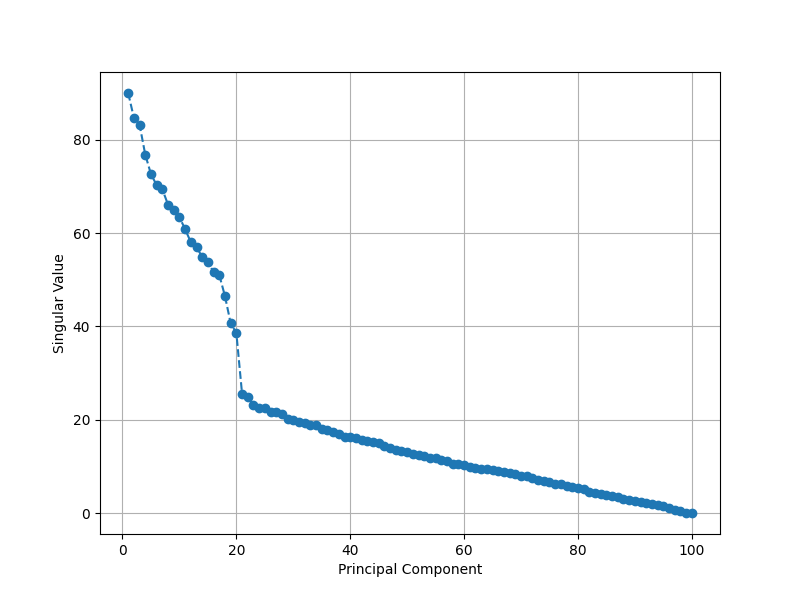

In [11]:
# Determine a suitable choice of L using a scree plot.
# Your code here

# Step 1: Center the data (subtract the mean of each feature)
mu = np.mean(X, axis=0)
X_centered = X - mu

# Step 2: Perform SVD
_, S, _ = np.linalg.svd(X_centered, full_matrices=False)

# Step 3: Plot the Scree Plot
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(S) + 1), S, marker='o', linestyle='--')
plt.xlabel('Principal Component')
plt.ylabel('Singular Value')
#plt.title('Scree Plot')
plt.grid(True)
plt.show()

In [12]:
# Determine a suitable choice of L using validation data.
split = len(X) * 3 // 4
X_train = X[:split,]
X_valid = X[split:,]

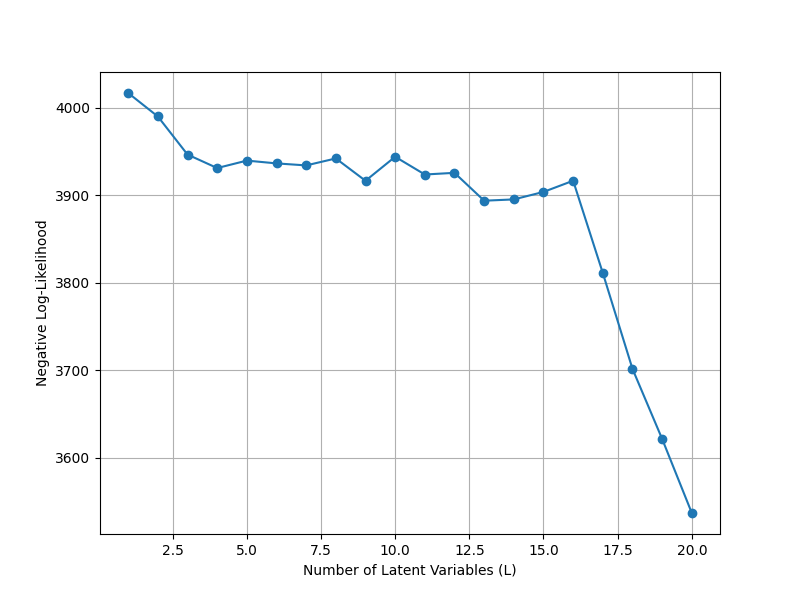

The best value for L based on validation data is 20.


In [13]:
# YOUR CODE HERE

# Fit PPCA models for different values of L and compute NLL on validation data
L_range = range(1, 21)  # Test values of L from 1 to 20
nll_values = []

for L in L_range:
    model = ppca_mle(X_train, L)
    nll = ppca_nll(X_valid, model)
    nll_values.append(nll)

# Plot NLL for different values of L
plt.figure(figsize=(8, 6))
plt.plot(L_range, nll_values, marker='o')
plt.xlabel('Number of Latent Variables (L)')
plt.ylabel('Negative Log-Likelihood')

#plt.title('Validation NLL for Different Latent Variables (L)')
plt.grid(True)
plt.show()

# Print the best L (with the lowest NLL)
best_L = L_range[np.argmin(nll_values)]
print(f"The best value for L based on validation data is {best_L}.")

# 2 Gaussian Mixture Models

## 2a) Toy data

In [14]:
# You do not need to modify this function.
def gmm_gen(N, mu, pi, Sigma=None, seed=None):
    """Generate data from a given GMM model.

    `N` is the number of data points to generate. `mu` and `Sigma` are lists with `K`
    elements holding the mean and covariance matrix of each mixture component. `pi` is a
    `K`-dimensional probability vector of component sizes.

    If `Sigma` is unspecified, a default (random) choice is taken.
    """
    K = len(pi)
    D = len(mu[0])
    rng = np.random.RandomState(seed)
    if Sigma is None:
        Sigma = [
            Q.transpose() @ np.diag([(k + 1) ** 2, k + 1]) @ Q
            for k, Q in enumerate([scipy.stats.ortho_group.rvs(2, random_state=rng) for k in range(K)])
        ]

    components = rng.choice(range(K), p=pi, size=N)
    X = np.zeros([N, D])
    for k in range(K):
        indexes = components == k
        N_k = np.sum(indexes.astype(np.int_))
        if N_k == 0:
            continue

        dist = scipy.stats.multivariate_normal(mean=mu[k], cov=Sigma[k], seed=rng)
        X[indexes, :] = dist.rvs(size=N_k)

    return dict(X=X, components=components, mu=mu, Sigma=Sigma, pi=pi)

-4380876.753061278


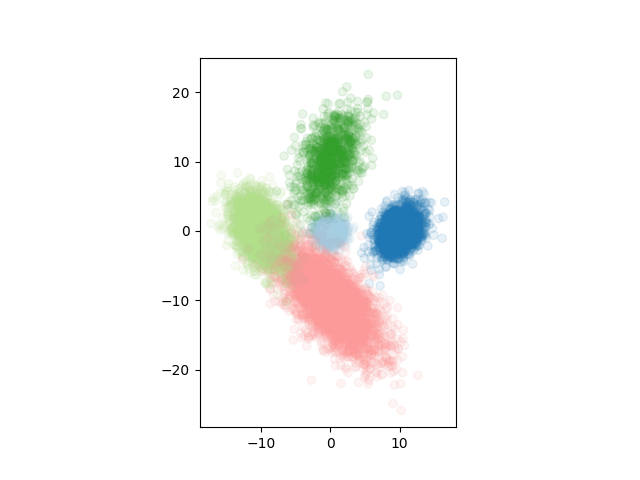

In [15]:
# Generate a toy dataset and plot it.
toy_gmm = gmm_gen(
    10000,
    [
        np.array([0, 0]),
        np.array([10, 0]),
        np.array([-10, 0]),
        np.array([0, 10]),
        np.array([0, -10]),
    ],
    np.array([0.1, 0.2, 0.25, 0.1, 0.35]),
    seed=4,
)

print(np.sum(toy_gmm["X"] ** 3))  # must be -4380876.753061278

plot_xy(toy_gmm["X"][:, 0], toy_gmm["X"][:, 1], toy_gmm["components"], alpha=0.1)

## 2b) K-Means

C:\Users\Welcome\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


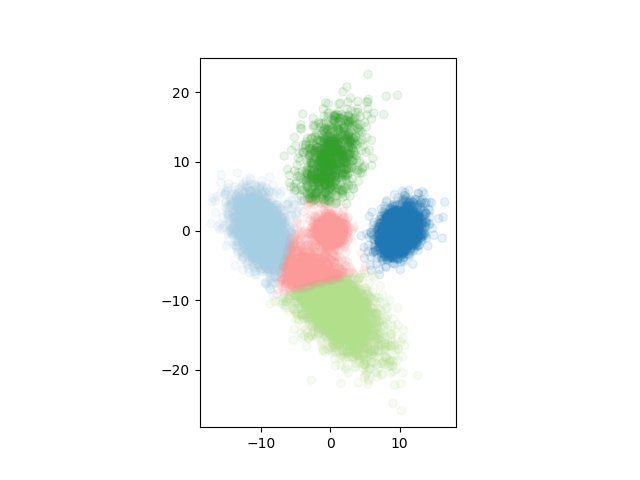

In [24]:
# Fit 5 clusters using k-means.
kmeans = KMeans(5).fit(toy_gmm["X"])
plot_xy(toy_gmm["X"][:, 0], toy_gmm["X"][:, 1], kmeans.labels_, alpha=0.1)

## 2c) Fit a GMM

In [27]:
from scipy.stats import multivariate_normal
def gmm_e(X, model, return_F=False):
    """Perform the E step of EM for a GMM (MLE estimate).

    `model` is a dictionary holding model parameters (keys `mu`, `Sigma`, and `pi`
    defined as in `gmm_gen`).

    Returns a NxK matrix of cluster membership probabilities. If `return_F` is true,
    also returns an NxK matrix holding the density of each data point (row) for each
    component (column).

    """
    mu, Sigma, pi = model["mu"], model["Sigma"], model["pi"]
    N, D = X.shape
    K = len(pi)

    # YOUR CODE HERE
    # Initialize F (NxK matrix for densities)
    F = np.zeros((N, K))

    # Compute F_ik = pi_k * N(x_i | mu_k, Sigma_k) for all i, k
    for k in range(K):
        dist = multivariate_normal(mean=mu[k], cov=Sigma[k])
        F[:, k] = pi[k] * dist.pdf(X)

    # Compute W (responsibilities) by normalizing F across clusters
    W = F / F.sum(axis=1, keepdims=True)

    # all done
    if return_F:
        return W, F
    else:
        return W

In [28]:
# Test your solution. This should produce:
# (array([[9.99999999e-01, 8.65221693e-10, 1.59675131e-23, 1.14015011e-41, 2.78010004e-65],
        # [1.00000000e+00, 3.75078862e-12, 1.55035521e-23, 1.28102693e-34, 1.86750812e-46],
        # [9.99931809e-01, 6.81161224e-05, 7.23302032e-08, 2.17176125e-09, 1.62736835e-10]]),
 # array([[1.71811600e-08, 5.94620494e-18, 1.82893598e-31, 9.79455071e-50, 1.59217812e-73],
        # [1.44159783e-15, 2.16285148e-27, 1.48999246e-38, 9.23362817e-50, 8.97398547e-62],
        # [1.85095927e-09, 5.04355064e-14, 8.92595932e-17, 2.01005787e-18, 1.00413265e-19]]))
dummy_model = dict(
    mu=[np.array([k, k + 1]) for k in range(5)],
    Sigma=[np.array([[3, 1], [1, 2]]) / (k + 1) for k in range(5)],
    pi=np.array([0.1, 0.25, 0.15, 0.2, 0.3]),
)
gmm_e(toy_gmm["X"][:3,], dummy_model, return_F=True)

(array([[9.99999999e-01, 8.65221693e-10, 1.59675131e-23, 1.14015011e-41,
         2.78010004e-65],
        [1.00000000e+00, 3.75078862e-12, 1.55035521e-23, 1.28102693e-34,
         1.86750812e-46],
        [9.99931809e-01, 6.81161224e-05, 7.23302032e-08, 2.17176125e-09,
         1.62736835e-10]]),
 array([[1.71811600e-09, 1.48655123e-18, 2.74340397e-32, 1.95891014e-50,
         4.77653437e-74],
        [1.44159783e-16, 5.40712871e-28, 2.23498869e-39, 1.84672563e-50,
         2.69219564e-62],
        [1.85095927e-10, 1.26088766e-14, 1.33889390e-17, 4.02011574e-19,
         3.01239795e-20]]))

In [29]:
def gmm_m(X, W):
    """Perform the M step of EM for a GMM (MLE estimate).

    `W` is the NxK cluster membership matrix computed in the E step. Returns a new model
    (dictionary with keys `mu`, `Sigma`, and `pi` defined as in `gmm_gen`).

    """
    N, D = X.shape
    K = W.shape[1]

    # YOUR CODE HERE
    # Compute effective cluster sizes
    N_k = W.sum(axis=0)  # Shape: (K,)

    # Compute mixing coefficients
    pi = N_k / N  # Shape: (K,)

    # Compute means
    mu = np.array([np.sum(W[:, k][:, np.newaxis] * X, axis=0) / N_k[k] for k in range(K)])  # Shape: (K, D)

    # Compute covariance matrices
    Sigma = []
    for k in range(K):
        X_centered = X - mu[k]  # Shape: (N, D)
        weighted_cov = (W[:, k][:, np.newaxis] * X_centered).T @ X_centered / N_k[k]  # Shape: (D, D)
        Sigma.append(weighted_cov)
    
    Sigma = np.array(Sigma)  # Shape: (K, D, D)

    return dict(mu=mu, Sigma=Sigma, pi=pi)

In [30]:
# Test your solution. This should produce:
# {'mu': [array([ 6.70641574, -0.47971125]),
#   array([8.2353509 , 2.52134815]),
#   array([-3.0476848 , -1.70722161])],
#  'Sigma': [array([[88.09488652, 11.08635139],
#          [11.08635139,  1.39516823]]),
#   array([[45.82761873, 11.38773232],
#          [11.38773232,  6.87352224]]),
#   array([[98.6662729 , 12.41671355],
#          [12.41671355,  1.56258842]])],
#  'pi': array([0.13333333, 0.53333333, 0.33333333])}
gmm_m(toy_gmm["X"][:3,], np.array([[0.1, 0.2, 0.7], [0.3, 0.4, 0.3], [0.0, 1.0, 0.0]]))

{'mu': array([[ 6.70641574, -0.47971125],
        [ 8.2353509 ,  2.52134815],
        [-3.0476848 , -1.70722161]]),
 'Sigma': array([[[88.09488652, 11.08635139],
         [11.08635139,  1.39516823]],
 
        [[45.82761873, 11.38773232],
         [11.38773232,  6.87352224]],
 
        [[98.6662729 , 12.41671355],
         [12.41671355,  1.56258842]]]),
 'pi': array([0.13333333, 0.53333333, 0.33333333])}

In [31]:
# you do not need to modify this method
def gmm_fit(X, K, max_iter=100, mu0=None, Sigma0=None, pi0=None, gmm_m=gmm_m):
    """Fit a GMM model using EM.

    `K` refers to the number of mixture components to fit. `mu0`, `Sigma0`, and `pi0`
    are initial parameters (automatically set when unspecified).

    """
    N, D = X.shape

    if mu0 is None:
        mu0 = [np.random.randn(D) for k in range(K)]
    if Sigma0 is None:
        Sigma0 = [np.eye(D) * 10 for k in range(K)]
    if pi0 is None:
        pi0 = np.ones(K) / K

    model = dict(mu=mu0, Sigma=Sigma0, pi=pi0)
    for it in range(max_iter):
        W = gmm_e(X, model)
        model = gmm_m(X, W)

    return model

## 2d+2e) Experiment with GMMs for the toy data

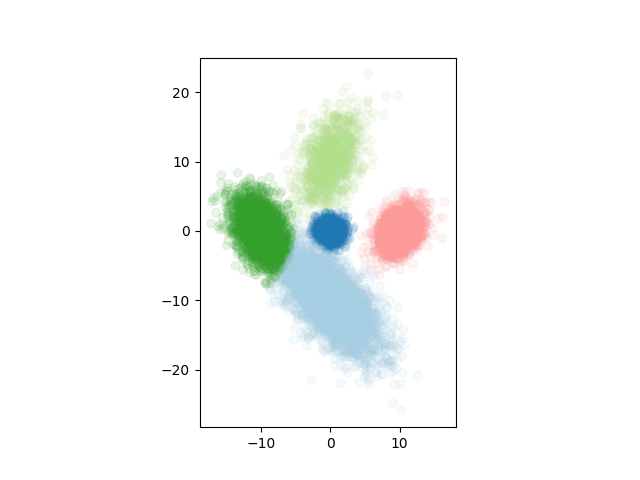

Fitting GMM with K = 4...


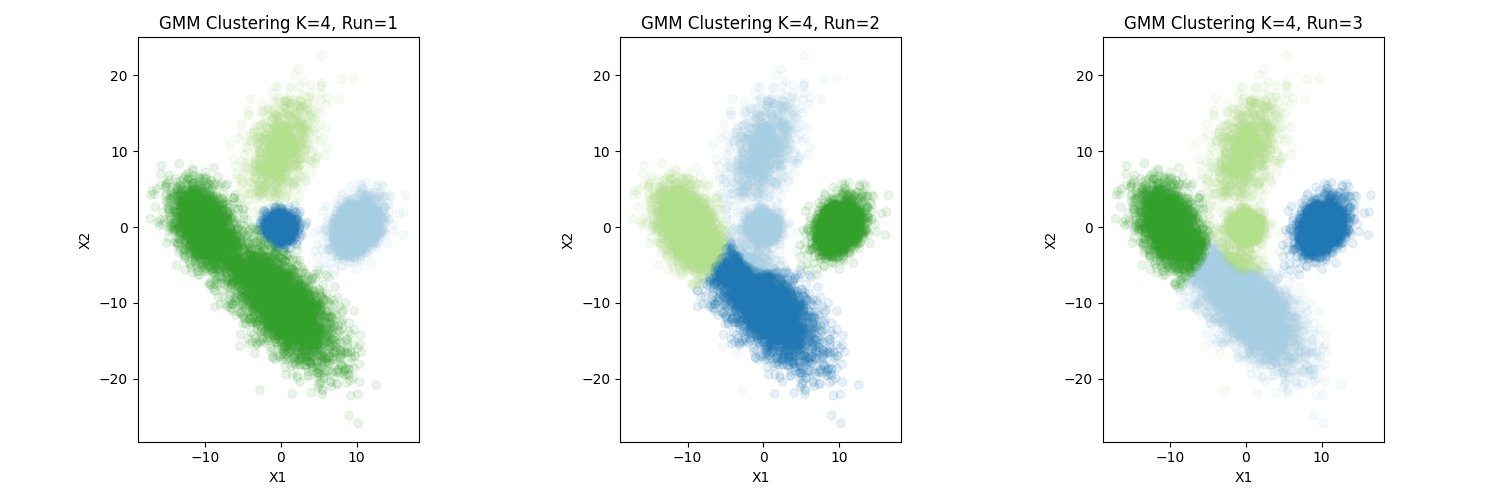

Fitting GMM with K = 6...


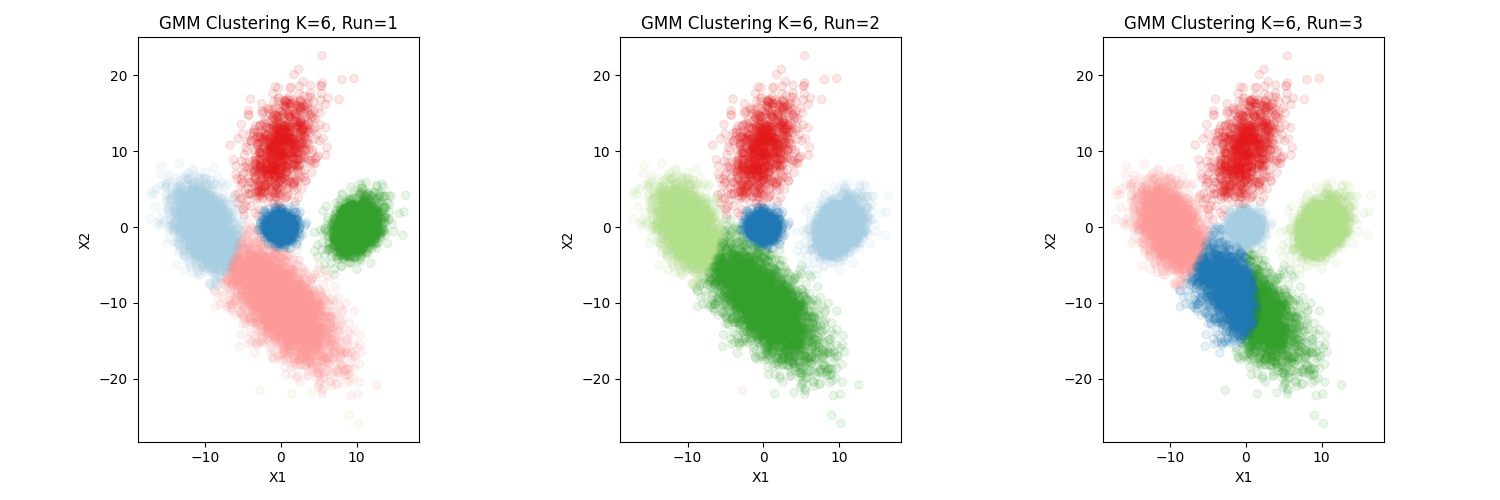

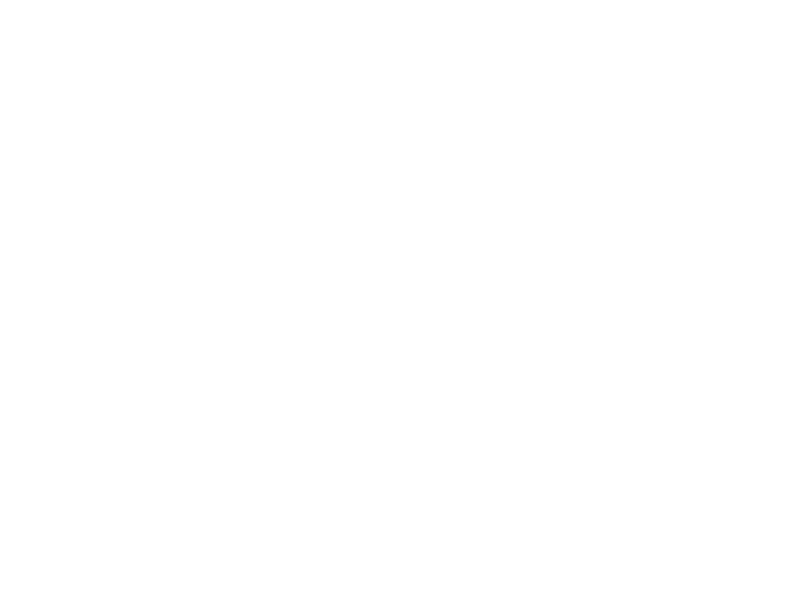

In [35]:
# Task d: Fit GMM with K = 5
toy_gmm_fit_5 = gmm_fit(toy_gmm["X"], 5)

# Compute responsibilities
W_5 = gmm_e(toy_gmm["X"], toy_gmm_fit_5)

# Assign each point to the most likely component
assignments_5 = np.argmax(W_5, axis=1)

# Plot the clustering for K = 5
plt.figure(figsize=(8, 6))
plot_xy(toy_gmm["X"][:, 0], toy_gmm["X"][:, 1], assignments_5, alpha=0.1)
#plt.title("GMM Clustering with K=5")
plt.show()

# Compare to K-Means clustering (already plotted in subtask b)


# Task e: Repeat with K = 4 and K = 6 using subplots
for K in [4, 6]:
    print(f"Fitting GMM with K = {K}...")

    plt.figure(figsize=(15, 5))  # Create a wide figure for subplots

    for repeat in range(3):
        toy_gmm_fit_k = gmm_fit(toy_gmm["X"], K)

        # Compute responsibilities
        W_k = gmm_e(toy_gmm["X"], toy_gmm_fit_k)

        # Assign each point to the most likely component
        assignments_k = np.argmax(W_k, axis=1)

        # Create a subplot for each repetition
        ax = plt.subplot(1, 3, repeat + 1)  # 1 row, 3 columns
        plot_xy(toy_gmm["X"][:, 0], toy_gmm["X"][:, 1], assignments_k, alpha=0.1, axis=ax)
        ax.set_title(f"GMM Clustering K={K}, Run={repeat + 1}")
        ax.set_xlabel("X1")
        ax.set_ylabel("X2")

    plt.tight_layout()  # Adjust layout to avoid overlap
    plt.show()

## 2f) Discover the Secret (optional)

In [36]:
# Load the secret data.
X = np.loadtxt("data/secret_gmm.csv", delimiter=",")

In [38]:
# How many components are hidden in this data?
X.shape

(1000, 10)

Shape of data: (1000, 10)


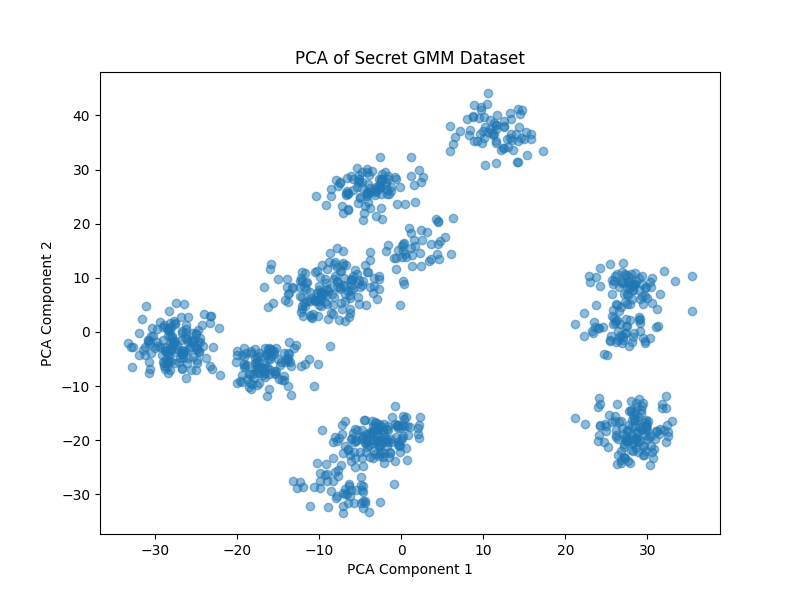

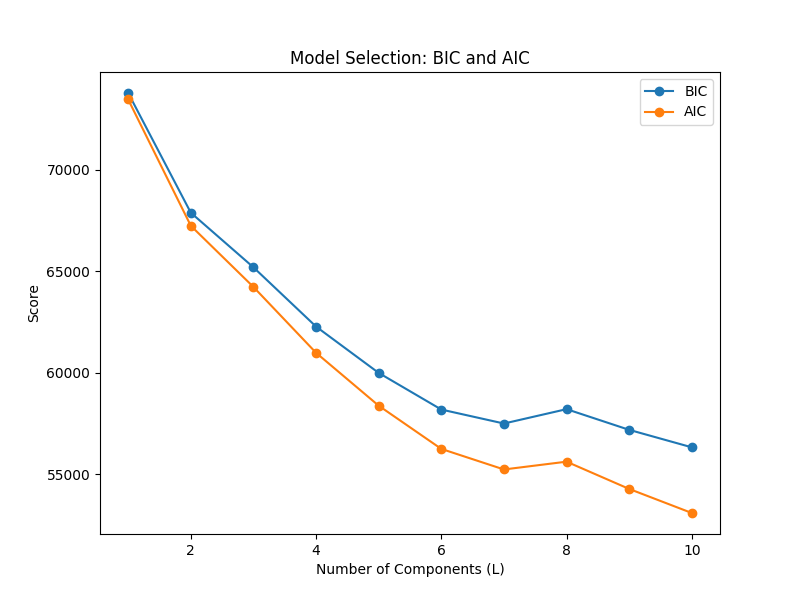

Optimal number of components based on BIC: 10
Optimal number of components based on AIC: 10


In [39]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.metrics import log_loss

# Load the secret data
X = np.loadtxt("data/secret_gmm.csv", delimiter=",")
print("Shape of data:", X.shape)

# Step 1: Visualize the data using PCA (reduce to 2D)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.5)
plt.title("PCA of Secret GMM Dataset")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

# Step 2: Fit GMM for different values of L and compute BIC/AIC
n_components_range = range(1, 11)  # Test from 1 to 10 components
bic_scores = []
aic_scores = []
log_likelihoods = []

for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=0)
    gmm.fit(X)
    
    # Compute BIC, AIC, and log-likelihood for the current model
    bic_scores.append(gmm.bic(X))
    aic_scores.append(gmm.aic(X))
    log_likelihoods.append(gmm.score(X) * len(X))  # Total log-likelihood

# Step 3: Plot BIC and AIC to determine the optimal number of components
plt.figure(figsize=(8, 6))
plt.plot(n_components_range, bic_scores, label='BIC', marker='o')
plt.plot(n_components_range, aic_scores, label='AIC', marker='o')
plt.xlabel('Number of Components (L)')
plt.ylabel('Score')
plt.title('Model Selection: BIC and AIC')
plt.legend()
plt.show()

# Step 4: Print the optimal number of components based on BIC or AIC
best_bic = np.argmin(bic_scores) + 1
best_aic = np.argmin(aic_scores) + 1

print(f"Optimal number of components based on BIC: {best_bic}")
print(f"Optimal number of components based on AIC: {best_aic}")